# Slater Koster Tight Binding

This notebook contains the original Slater Koster model, as well as my position based Hamiltonian-Symmetry. It serves as a comparison between the two, as they are quite similar.

In [7]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import hamiltonian_symmetry as hsym
import fermi_surface as fs
import kpaths

Symmetries: 48
neighbors: 27
model sym: 1
final loss: 8.29e-02 (max band-error [0.153 0.103 0.101 0.158 0.087 0.14  0.118 0.138 0.186 0.226 0.157 0.557])


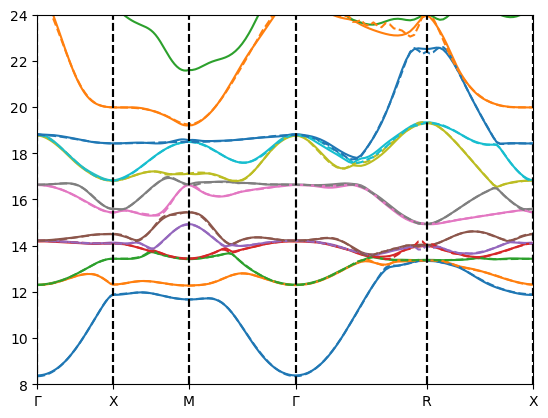

In [8]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]

k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

hsym_nitinol = hsym.HamiltonianSymmetry(Symmetry.cubic(True), np.eye(3))
# TODO look at wannier function to find out which energy belongs to which atom
#hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0, 0, 0], "Ni")
#hsym_nitinol.append_d2([0, 0, 0], "Ni")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_p([0, 0, 0], "Ni")

hsym_nitinol.append_s([0, 0, 0], "Ti")
hsym_nitinol.append_d2([0, 0, 0], "Ti")
hsym_nitinol.append_d3([0, 0, 0], "Ni")
hsym_nitinol.append_d2([0, 0, 0], "Ni")
hsym_nitinol.append_d3([0, 0, 0], "Ti")
hsym_nitinol.append_d3([0, 0, 0], "Ni")

#hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ni")
#hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ni")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
#hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ni")

# now start my algorithm to find good matrices
additional_bands = len(hsym_nitinol) - len(ref_bands[0])
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

#tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=False, exp=True)
#tb_nitinol.symmetrizer = hsym_nitinol.symmetrizer(neighbors) # for this: cos_reduced=False, exp=True
tb_nitinol = BandStructureModel.load("ni_asym.repr")
print("neighbors:", len(tb_nitinol.params))
print("model sym:", len(tb_nitinol.sym))
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 5, 1, train_k0=True, max_accel_global=1.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 50, 1, train_k0=True, max_accel_global=8.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4, train_k0=True, regularization=0.999)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 0, 2, learning_rate=0.0) # just show the error

#k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [9]:
#tb_nitinol.save("ni_sym.repr")

final loss: 3.04e-01 (max band-error [0.166 0.411 0.248 0.322 0.507 0.378 0.332 0.41  0.382 0.309 0.874 0.902])


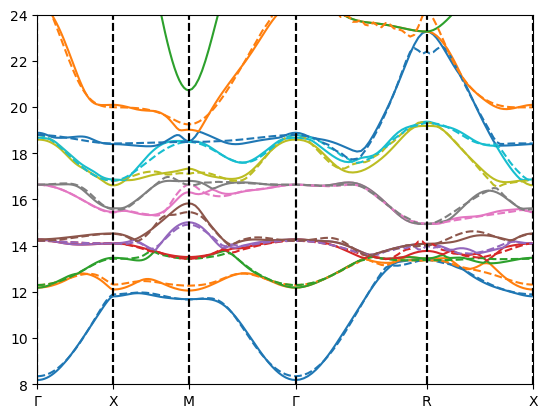

In [10]:
#band_weights = np.exp(-np.mean(ref_bands - fermi_energy, axis=0)**2/2 / 3.0**2)
#band_weights[12:] *= 0.1
tb_nitinol = BandStructureModel.load("sym_nitinol13.json")
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 0, 2)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

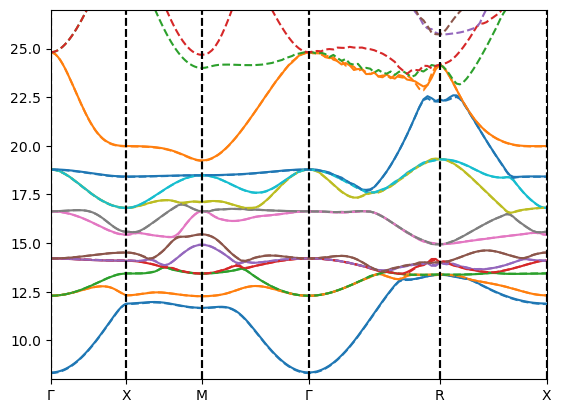

In [11]:
import qespresso_interface as qe
material2 = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl2, _, ref_bands2, symmetries2, fermi_energy2 = material2.read_bands()
k_smpl2, ref_bands2 = Symmetry(symmetries).realize_symmetric_data(k_smpl2, ref_bands2)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
interpolator2 = kpaths.interpolate(k_smpl2, ref_bands2[:,8:], Symmetry.none(), method='cubic')
path.plot(interpolator, '-')
path.plot(interpolator2, '--')
plt.ylim(8, 27)
plt.show()

band weights: [0.51 0.7  0.78 0.83 0.87 0.91 1.   1.   0.96 0.89 0.79 0.47 0.01 0.   0.   0.  ]
preparing pseudoinverse
maximal acceleration 2.0
final loss: 2.02e-01 (max band-error [ 0.32  0.16  0.11  0.13  0.13  0.13  0.16  0.12  0.16  0.2   0.63  0.9   2.6   3.39  7.49 13.15])
16.219224072699138


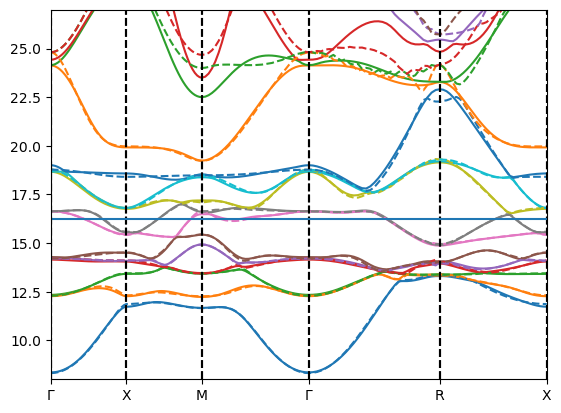

In [28]:
tb_nitinol = BandStructureModel.load("bruinsma_improved.json")
#tb_nitinol.params[0] += np.eye(len(tb_nitinol.params[0])) * 7.1
band_weights = np.exp(-np.mean(ref_bands2[:,8:] - fermi_energy2, axis=0)**2/2 / 4.0**2)
band_weights[12:] *= 0.1
print("band weights:", band_weights)
tb_nitinol.optimize(k_smpl2, 1, ref_bands2[:,8:], band_weights, 0, 0, 1, max_accel_global=2.0, use_pinv=True, keep_zeros=True)

import density_of_states as dos
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=20, ranges=((-0.5, 0.5),)*3, wrap=True)
fermi_energy = dos_nitinol.fermi_energy(7)
print(fermi_energy)

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
#interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
interpolator2 = kpaths.interpolate(k_smpl2, ref_bands2[:,8:], Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
#path.plot(interpolator, '--')
path.plot(interpolator2, '--')
plt.axhline(fermi_energy)
plt.ylim(8, 27)
plt.show()

In [13]:
#tb_nitinol.save("bruinsma_improved.json")

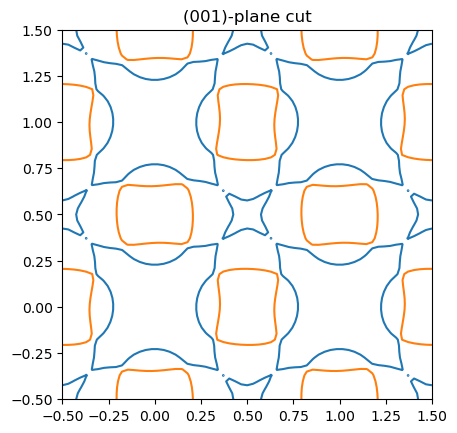

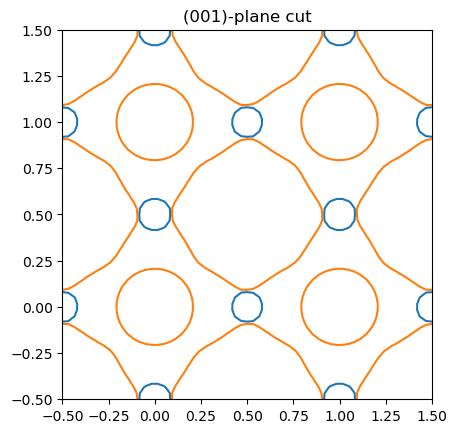

In [27]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63, k_range=[-0.5, 1.5])

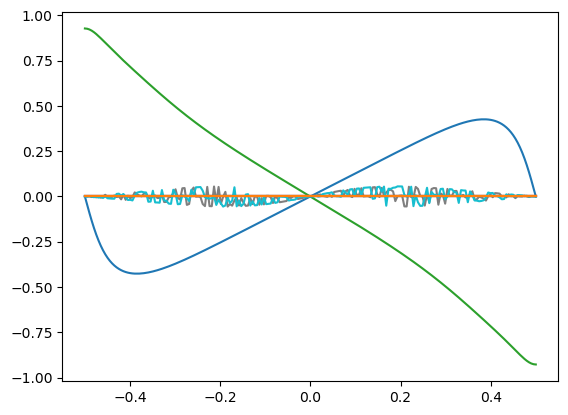

In [15]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

In [16]:
np.set_printoptions(precision=2, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-4]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, -1e-4]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
print(Uk1)

[-1.-0.08j -1.+0.08j -1.-0.j   -1.+0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.-0.j    1.+0.j    1.+0.j  ]
[[ 0.99+0.j  0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  -0.j -0.  +0.j -0.12+0.j]
 [-0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.03+0.j -1.  +0.j -0.  +0.j -0.  +0.j  0.01+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  1.  +0.j -0.03+0.j  0.  +0.j -0.01+0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j -1.  +0.j -0.  +0.j  0.  +0.j -0.01+0.j -0.  +0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.  +0.j  0.  +0.j  0.  +0.j -0.  +0.j  0.96+0.j  0.  +0.j -0.  +0.j  0. 